In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity

### Definitions

Setting $n$ and $p$ for $ER_n(p)$, $ER$ being Erdos-Renyi

In [64]:
# Add some kind of diagnostic to check for n*alpha and n * beta >> logn

def generate_An(n: int, p: float):
    An = np.random.binomial(1, p, size=(n, n))
    np.fill_diagonal(An, val=0)
    An[np.tril_indices(n, k=-1)] = An.T[np.tril_indices(n, k=-1)]

    return An


def generate_Dn(An):
    n = An.shape[0]
    Dn = np.zeros(shape=(n, n))
    degrees = np.matrix(An).sum(axis=1)
    np.fill_diagonal(Dn, degrees)
    Dn = Dn.astype(int)

    return Dn


def generate_Deltan(An, Dn):
    laplacian = Dn - An

    return laplacian


def generate_Ln(An):
    n = An.shape[0]
    degrees = np.matrix(An).sum(axis=1)
    degrees_inv_sqrt = 1/np.sqrt(degrees)
    Dn_inv_sqrt = np.zeros(shape=(n, n))
    np.fill_diagonal(Dn_inv_sqrt, degrees_inv_sqrt)

    Ln = np.identity(n) - np.matmul(np.matmul(Dn_inv_sqrt,An), Dn_inv_sqrt)

    return Ln


def normalized_An_spectra(An, p):
    n = An.shape[0]
    centered_An = An - p
    normed_centered_An = centered_An * 1/np.sqrt(n * p * (1 - p))
    eigen_normed_An = np.linalg.eigvalsh(normed_centered_An)

    return eigen_normed_An


def normalized_Deltan_spectra(Deltan, p, x_range = np.linspace(-5, 5, 100)):
    n = Deltan.shape[0]
    normed_centered_eigen_Laplacian_n = (np.linalg.eigvalsh(Deltan) - n * p) /(np.sqrt(n * p * (1 -p)))
    Fn_Laplacian = [np.sum(normed_centered_eigen_Laplacian_n <= x)/n for x in x_range]

    return np.diff(Fn_Laplacian)


def normalized_Ln_spectra(Ln, p, x_range = np.linspace(-5, 5, 100), block_probabilities = [0.5, 0.5]):
    n = Ln.shape[0]
    eigen_Ln = np.linalg.eigvalsh(Ln)
    normed_centered_eigen_Ln = (1 - eigen_Ln) * np.sqrt((n * block_probabilities[0] * block_probabilities[1] * 4)/(sum(block_probabilities)))
    Fn_Normed_Laplacian = [np.sum(normed_centered_eigen_Ln <= x)/n for x in x_range]

    return np.diff(Fn_Normed_Laplacian)


def generate_block_matrix(n, block_probabilities: list, return_sizes=False):
    n_blocks = len(block_probabilities)
    block_proportions = np.random.random(n_blocks)
    block_proportions_total = np.sum(block_proportions)
    block_proportions_normed = block_proportions/block_proportions_total

    block_sizes = [round(x) for x in block_proportions_normed * n]
    blocks = []
    i_idx = 0
    j_idx = 0

    for block_p, block_n in zip(block_probabilities, block_sizes):
        block = generate_An(block_n, block_p)
        if i_idx == 0:
            zero_x_dim = n - block_n
            zero_y_dim = block_n
            block_row = [block, 
                        np.zeros(shape=(zero_y_dim, zero_x_dim))]
        elif i_idx == n - block_sizes[-1]:
            zero_x_dim = n - block_n
            zero_y_dim = block_n
            block_row = [np.zeros(shape=(zero_y_dim, zero_x_dim)), 
                        block]
        else:
            zero_x_dim_1 = i_idx
            zero_x_dim_2 = n - block_n - i_idx
            zero_y_dim = block_n
            block_row = [np.zeros(shape=(zero_y_dim, zero_x_dim_1)),
                        block,
                        np.zeros(shape=(zero_y_dim, zero_x_dim_2))]

        i_idx += block_n
        j_idx += block_n

        blocks.append(block_row)

    block_matrix = np.block(blocks)

    if return_sizes:
        return block_matrix, block_sizes
    else:
        return block_matrix


def generate_Cn_block(An, p):
    n = An.shape[0]
    degrees = np.matrix(An).sum(axis=1)
    degrees_inv_sqrt = 1/np.sqrt(degrees)
    Dn_inv_sqrt = np.zeros(shape=(n, n))
    np.fill_diagonal(Dn_inv_sqrt, degrees_inv_sqrt)
    expected_An = np.full(shape=(n, n), fill_value=p)
    centered_An = An - expected_An

    Cn = np.matmul(np.matmul(Dn_inv_sqrt, centered_An), Dn_inv_sqrt)
    scaled_Cn = np.sqrt(n * p) *  Cn

    return scaled_Cn


def generate_Cn_hat_block(An, p):
    n = An.shape[0]
    degrees = np.matrix(An).sum(axis=1)
    degrees_inv_sqrt = 1/np.sqrt(degrees)
    Dn_inv_sqrt = np.zeros(shape=(n, n))
    np.fill_diagonal(Dn_inv_sqrt, degrees_inv_sqrt)

    Cn_hat = np.matmul(np.matmul(Dn_inv_sqrt, An), Dn_inv_sqrt)
    scaled_Cn_hat = np.sqrt(n * p) * Cn_hat

    return scaled_Cn_hat


def generate_Cn(An,
                block_probabilities: list,
                block_sizes: list):
    block_idx_i = 0
    block_elements = []
    n = An.shape[0]
    for block_p, block_size in zip(block_probabilities, block_sizes):
        An_indices = list(range(0 + block_idx_i, block_size + block_idx_i))
        block = An[np.ix_(An_indices, An_indices)]
        block_Cn = generate_Cn_block(block, block_p)

        if block_idx_i == 0:
            zero_x_dim = n - block_size
            zero_y_dim = block_size
            block_row = [block_Cn, 
                        np.zeros(shape=(zero_y_dim, zero_x_dim))]
        elif block_idx_i == n - block_sizes[-1]:
            zero_x_dim = n - block_size
            zero_y_dim = block_size
            block_row = [np.zeros(shape=(zero_y_dim, zero_x_dim)),
                         block_Cn]
        else:
            zero_x_dim_1 = block_idx_i
            zero_x_dim_2 = n - block_size - block_idx_i
            zero_y_dim = block_size
            block_row = [np.zeros(shape=(zero_y_dim, zero_x_dim_1)),
                        block_Cn,
                        np.zeros(shape=(zero_y_dim, zero_x_dim_2))]

        block_elements.append(block_row)
        block_idx_i += block_size
    full_Cn = np.block(block_elements)
    return full_Cn


def generate_Cn_hat(An,
                block_probabilities: list,
                block_sizes: list):
    block_idx_i = 0
    block_elements = []
    n = An.shape[0]
    for block_p, block_size in zip(block_probabilities, block_sizes):
        print(block_size)
        An_indices = list(range(0 + block_idx_i, block_size + block_idx_i))
        block = An[np.ix_(An_indices, An_indices)]
        block_Cn = generate_Cn_hat_block(block, block_p)

        if block_idx_i == 0:
            zero_x_dim = n - block_size
            zero_y_dim = block_size
            block_row = [block_Cn, 
                        np.zeros(shape=(zero_y_dim, zero_x_dim))]
        elif block_idx_i == n - block_sizes[-1]:
            zero_x_dim = n - block_size
            zero_y_dim = block_size
            block_row = [np.zeros(shape=(zero_y_dim, zero_x_dim)),
                         block_Cn]
        else:
            zero_x_dim_1 = block_idx_i
            zero_x_dim_2 = n - block_size - block_idx_i
            zero_y_dim = block_size
            block_row = [np.zeros(shape=(zero_y_dim, zero_x_dim_1)),
                        block_Cn,
                        np.zeros(shape=(zero_y_dim, zero_x_dim_2))]

        block_elements.append(block_row)
        block_idx_i += block_size
    full_Cn = np.block(block_elements)
    return full_Cn

In [81]:
n = 5000
probabilities = [0.8, 0.7]

block_An, block_sizes = generate_block_matrix(n=n,
                                 block_probabilities=probabilities,
                                 return_sizes=True)
Dn = generate_Dn(block_An)
laplacian = generate_Deltan(block_An, Dn)
Ln = generate_Ln(block_An)
eigen_An = np.linalg.eigvalsh(block_An)
eigen_normed_An = normalized_An_spectra(block_An, p)
eigen_Ln = np.linalg.eigvalsh(Ln)
eigen_Laplacian_n = np.linalg.eigvalsh(laplacian)
Fn_Laplacian = normalized_Deltan_spectra(laplacian, p)
Fn_Normed_Laplacian = normalized_Ln_spectra(Ln, p)

Text(0.5, 1.0, 'Spectral Distribution of $A_N, N=5000$, $A_N$ being block matrix with block probabilities $p=[0.8, 0.7]$')

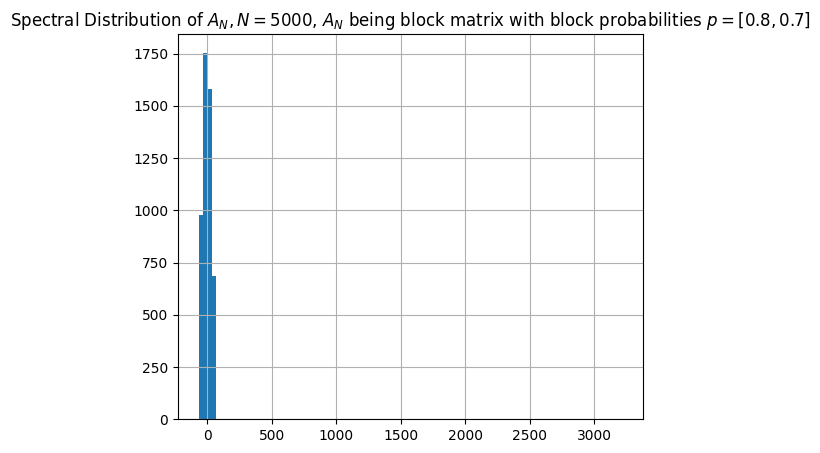

In [82]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.hist(eigen_An,
        bins=100)
ax.grid()

ax.set_title("Spectral Distribution of $A_N, N=%s$, $A_N$ being block matrix with block probabilities $p=%s$" % (n, probabilities))

# ax.text(x=max(eigen_An),
#         y=250,
#         s=r'$\lambda_{max}(A_n)=%.2f$' % max(eigen_An),
#         ha="center",
#         size="large")

# ax.arrow(x=max(eigen_An),
#          y=250,
#          dx=0,
#          dy=-200,
#          length_includes_head=True,
#          head_width=50, head_length=50,
#          color='red')

# ax.text(x=eigen_An[-2],
#         y=250,
#         s=r'$\lambda_{max_2}(A_n)=%.2f$' % eigen_An[-2],
#         ha="center",
#         size="large")

# ax.arrow(x=eigen_An[-2],
#          y=250,
#          dx=0,
#          dy=-200,
#          length_includes_head=True,
#          head_width=50, head_length=50,
#          color='red')

# do you scale each block in a block matr

Text(0.5, 1.0, 'Spectral Distribution of Centered, Normalized $\\hat{A}_N, N=5000$, $A_N$ being block matrix with block probabilities $p=[0.8, 0.7]$')

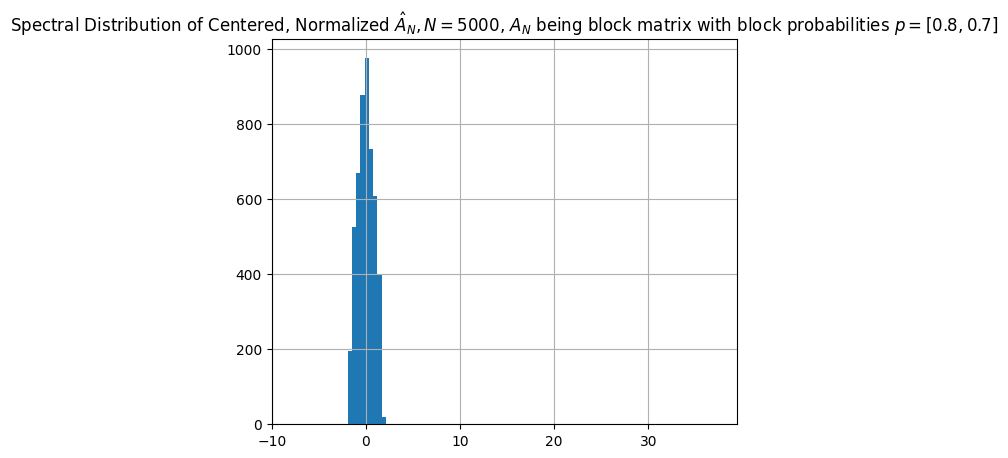

In [83]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.hist(eigen_normed_An,
        bins=100)
ax.grid()

# ax.text(x=max(eigen_normed_An),
#         y=260,
#         s=r'$\lambda_{max}(\hat{A}_n)=%.2f$' % max(eigen_normed_An),
#         ha="center",
#         size="large")

# ax.arrow(x=max(eigen_normed_An),
#          y=250,
#          dx=0,
#          dy=-200,
#          length_includes_head=True,
#          head_width=1.5, head_length=50,
#          color='red')

# ax.text(x=min(eigen_normed_An),
#         y=260,
#         s=r'$\lambda_{min}(\hat{A}_n)=%.2f$' % min(eigen_normed_An),
#         ha="center",
#         size="large")

# ax.arrow(x=min(eigen_normed_An),
#          y=250,
#          dx=0,
#          dy=-200,
#          length_includes_head=True,
#          head_width=1.5, head_length=50,
#          color='red')

ax.set_title("Spectral Distribution of Centered, Normalized $\hat{A}_N, N=%s$, $A_N$ being block matrix with block probabilities $p=%s$" % (n, probabilities))

Text(0.5, 1.0, 'Spectral Distribution of Centered, Normalized $\\hat{A}_N, N=5000$, Excluding $\\lambda_{min}$ and $\\lambda_{max}$')

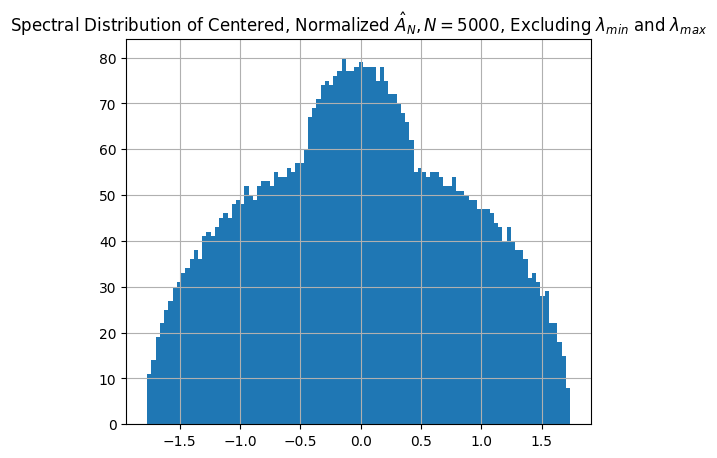

In [84]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.hist(eigen_normed_An[1:-1],
        bins=100)
ax.grid()

ax.set_title("Spectral Distribution of Centered, Normalized $\hat{A}_N, N=%s$, Excluding $\lambda_{min}$ and $\lambda_{max}$" % (n))

410
4590


Text(0.5, 0.98, 'Centered vs. Uncentered Spectral Distributions for Normalized $\\hat{A}_n$, $n=5000, p=[0.8, 0.7]$')

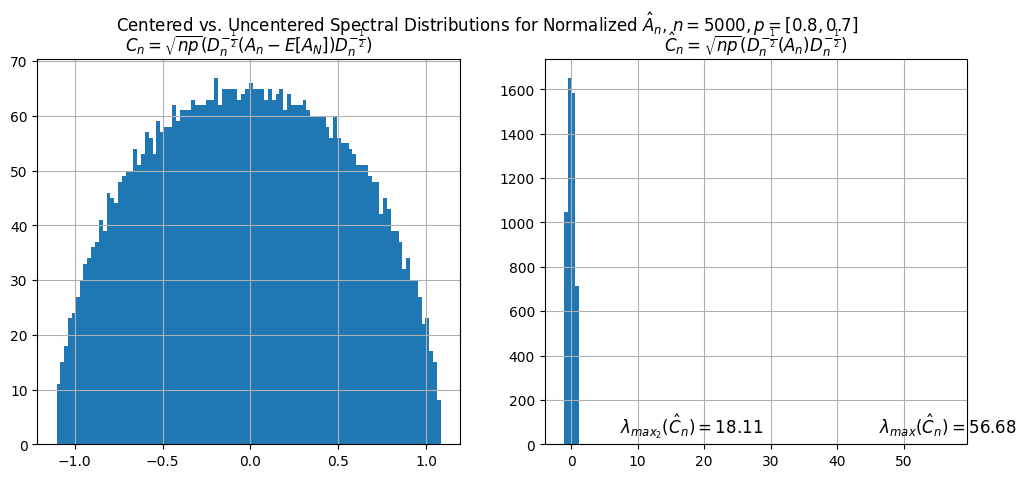

In [88]:
### Need to sort out how to center an inhomogeneous block matrix wrt individual grahons

Cn = generate_Cn(block_An, probabilities, block_sizes)
Cn_hat = generate_Cn_hat(block_An, probabilities, block_sizes)

eigen_Cn = np.linalg.eigvalsh(Cn)
eigen_Cn_hat = np.linalg.eigvalsh(Cn_hat)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].hist(eigen_Cn,
            bins=100)
axs[0].grid()
axs[0].set_title(r'$C_n=\sqrt{np}(D_n^{-\frac{1}{2}}(A_n-E[A_N])D_n^{-\frac{1}{2}})$')

axs[1].hist(eigen_Cn_hat,
            bins=100)
axs[1].grid()
axs[1].set_title(r'$\hat{C}_n=\sqrt{np}(D_n^{-\frac{1}{2}}(A_n)D_n^{-\frac{1}{2}})$')
axs[1].text(x=max(eigen_Cn_hat),
            y=50,
            s=r'$\lambda_{max}(\hat{C}_n)=%.2f$' % max(eigen_Cn_hat),
            ha="center",
            size="large")
axs[1].text(x=eigen_Cn_hat[-2],
            y=50,
            s=r'$\lambda_{max_2}(\hat{C}_n)=%.2f$' % eigen_Cn_hat[-2],
            ha="center",
            size="large")

fig.suptitle(r'Centered vs. Uncentered Spectral Distributions for Normalized $\hat{A}_n$, $n=%s, p=%s$' % (n, probabilities))

In [90]:
np.sqrt(5000 * 0.8)

63.245553203367585

In [91]:
np.sqrt(5000 * 0.7)

59.16079783099616